# 1.31k: Forces Over Time

**Goal:** Visualize the three components of the AdamW update over training.

For each timestep, we compute:
1. **Displacement norm**: $|\Delta W_t| = |W_t - W_{t-1}|$
2. **Momentum norm**: $|\hat{m}_t|$ (bias-corrected)
3. **Variance norm**: $|\sqrt{\hat{v}_t}|$ (bias-corrected, element-wise sqrt then norm)

These show the forces driving token motion during training.

**Memory budget:** Loading first 3000 timesteps ≈ 11.88 GB (well under 24 GB limit).

In [28]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

# Hyperparameters
LEARNING_RATE = 1e-3
BETA1 = 0.9
BETA2 = 0.999
EPS = 1e-8

# Loading
NUM_STEPS = 3000

# Plotting
DPI = 200

In [29]:
# Load first 3000 timesteps
h5_path = Path('../tensors/Thimble/thimble_7.h5')

print(f"Loading {NUM_STEPS} timesteps...")
with h5py.File(h5_path, 'r') as f:
    W_uint16 = torch.from_numpy(f['W'][:NUM_STEPS+1, :, :])
    m_uint16 = torch.from_numpy(f['momentum_W'][:NUM_STEPS+1, :, :])
    v_uint16 = torch.from_numpy(f['variance_W'][:NUM_STEPS+1, :, :])

# Convert to bfloat16
W = W_uint16.view(torch.bfloat16)
m = m_uint16.view(torch.bfloat16)
v = v_uint16.view(torch.bfloat16)

print(f"Loaded W: {W.shape} ({W.dtype})")
print(f"Loaded m: {m.shape} ({m.dtype})")
print(f"Loaded v: {v.shape} ({v.dtype})")

num_tokens = W.shape[1]
num_dims = W.shape[2]

Loading 3000 timesteps...
Loaded W: torch.Size([3001, 10000, 64]) (torch.bfloat16)
Loaded m: torch.Size([3001, 10000, 64]) (torch.bfloat16)
Loaded v: torch.Size([3001, 10000, 64]) (torch.bfloat16)


In [38]:
# Preallocate norm arrays
dW_norms = torch.zeros(NUM_STEPS, num_tokens)
m_hat_norms = torch.zeros(NUM_STEPS, num_tokens)
sqrt_v_hat_norms = torch.zeros(NUM_STEPS, num_tokens)

print("Computing norms...")
for t in tqdm(range(1, NUM_STEPS+1)):
    idx = t - 1
    
    # Displacement norm
    dW = (W[t] - W[t-1]).to(torch.float32)
    dW_norms[idx] = torch.norm(dW, dim=1)
    
    # Bias-corrected momentum norm
    m_hat = m[t].to(torch.float32) / (1 - BETA1**t)
    m_hat_norms[idx] = torch.norm(m_hat, dim=1)
    
    # Bias-corrected variance norm (element-wise sqrt, then norm)
    v_hat = v[t].to(torch.float32) / (1 - BETA2**t)
    sqrt_v_hat = torch.sqrt(v_hat + EPS)
    sqrt_v_hat_norms[idx] = torch.norm(sqrt_v_hat, dim=1)

print(f"\nComputed norms for {NUM_STEPS} timesteps and {num_tokens:,} tokens.")

Computing norms...


100%|██████████| 3000/3000 [00:02<00:00, 1231.03it/s]


Computed norms for 3000 timesteps and 10,000 tokens.


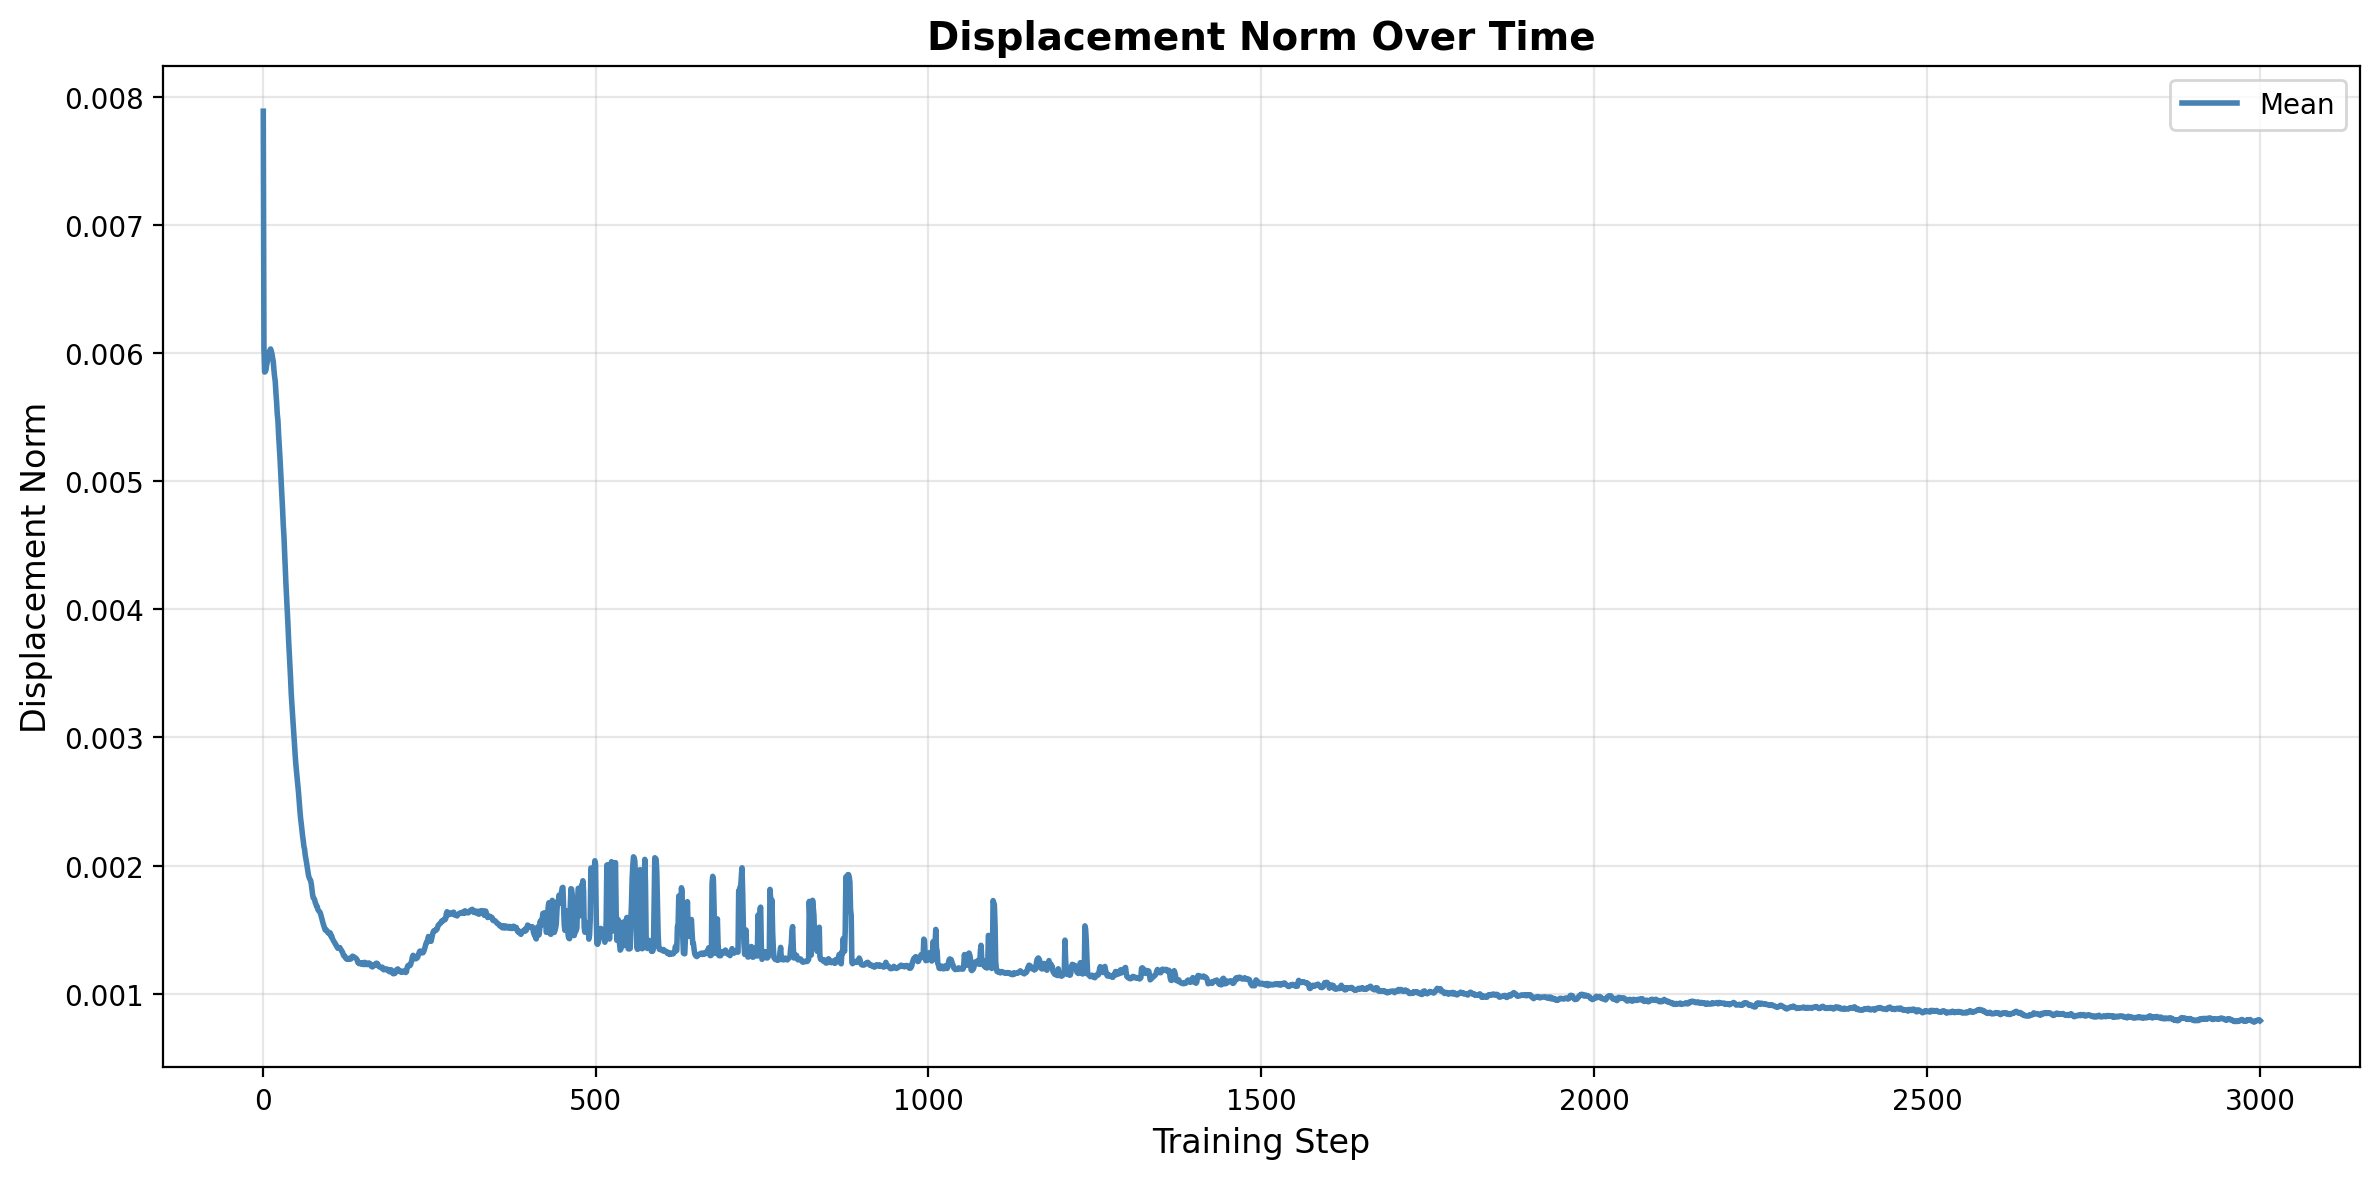

In [43]:
# Plot 1: Displacement norm over time
fig, ax = plt.subplots(figsize=(12, 6), dpi=DPI)

timesteps = np.arange(1, NUM_STEPS+1)

# All tokens (faint)
# for i in range(num_tokens):
    # ax.plot(timesteps, dW_norms[:, i].numpy(), color='gray', alpha=0.005, linewidth=0.5)

# Mean (bold)
ax.plot(timesteps, dW_norms.mean(dim=1).numpy(), color='steelblue', linewidth=2, label='Mean')

ax.set_xlabel('Training Step', fontsize=12)
ax.set_ylabel('Displacement Norm', fontsize=12)
ax.set_yscale('linear')
ax.set_title('Displacement Norm Over Time', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

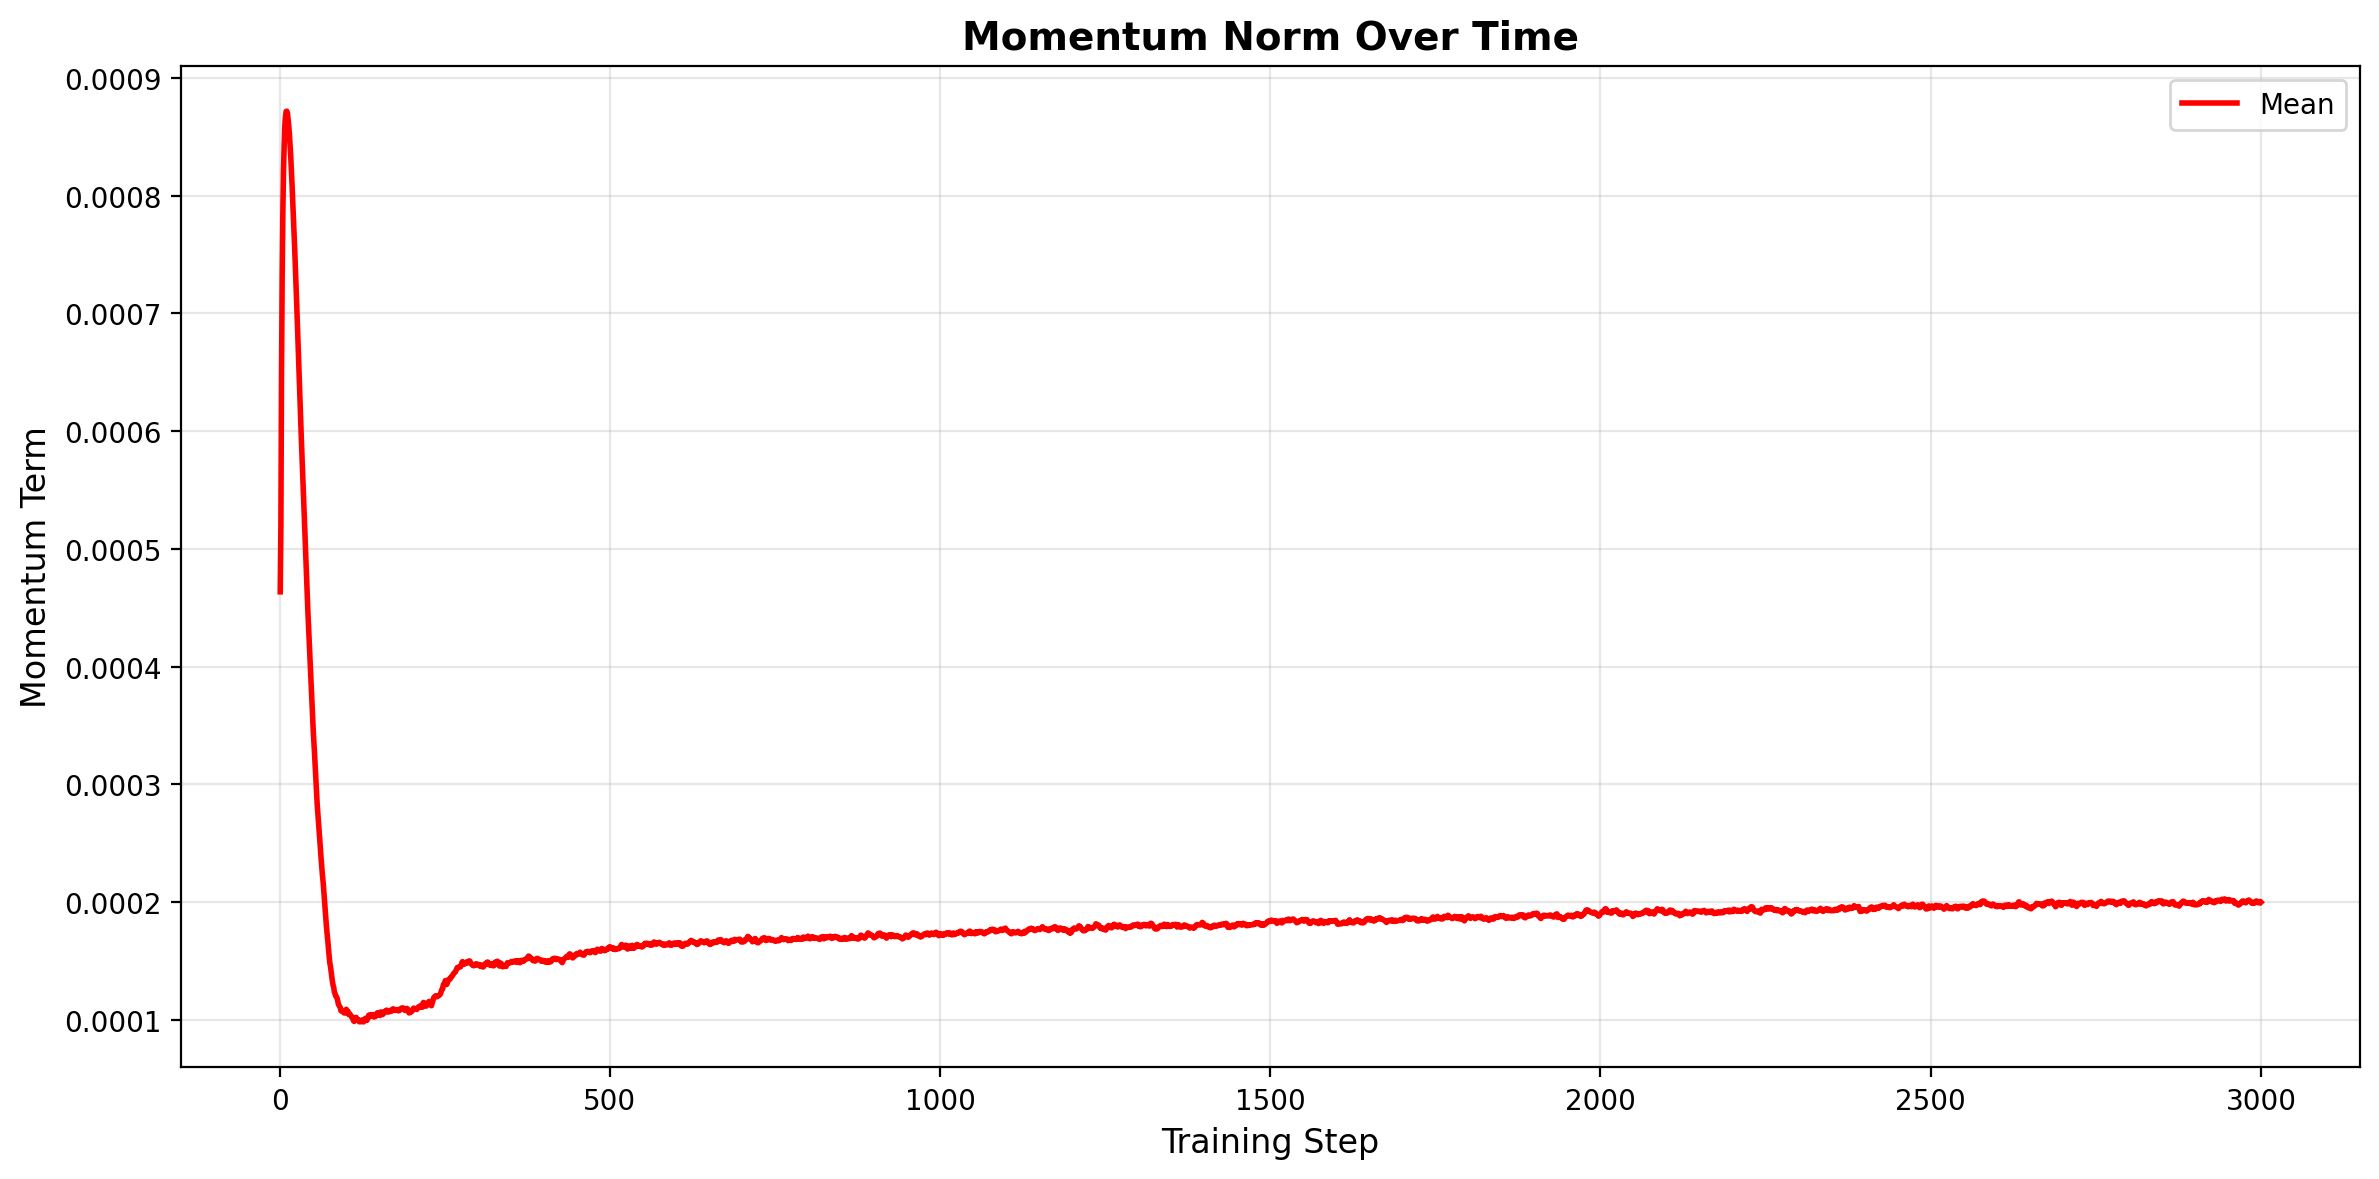

In [40]:
# Plot 2: Momentum norm over time
fig, ax = plt.subplots(figsize=(12, 6), dpi=DPI)

# All tokens (faint)
# for i in range(num_tokens):
#     ax.plot(timesteps, m_hat_norms[:, i].numpy(), color='steelblue', alpha=0.005, linewidth=0.5)

# Mean (bold)
ax.plot(timesteps, m_hat_norms.mean(dim=1).numpy(), color='red', linewidth=2, label='Mean')

ax.set_xlabel('Training Step', fontsize=12)
ax.set_ylabel('Momentum Term', fontsize=12)
ax.set_yscale('linear')
ax.set_title('Momentum Norm Over Time', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

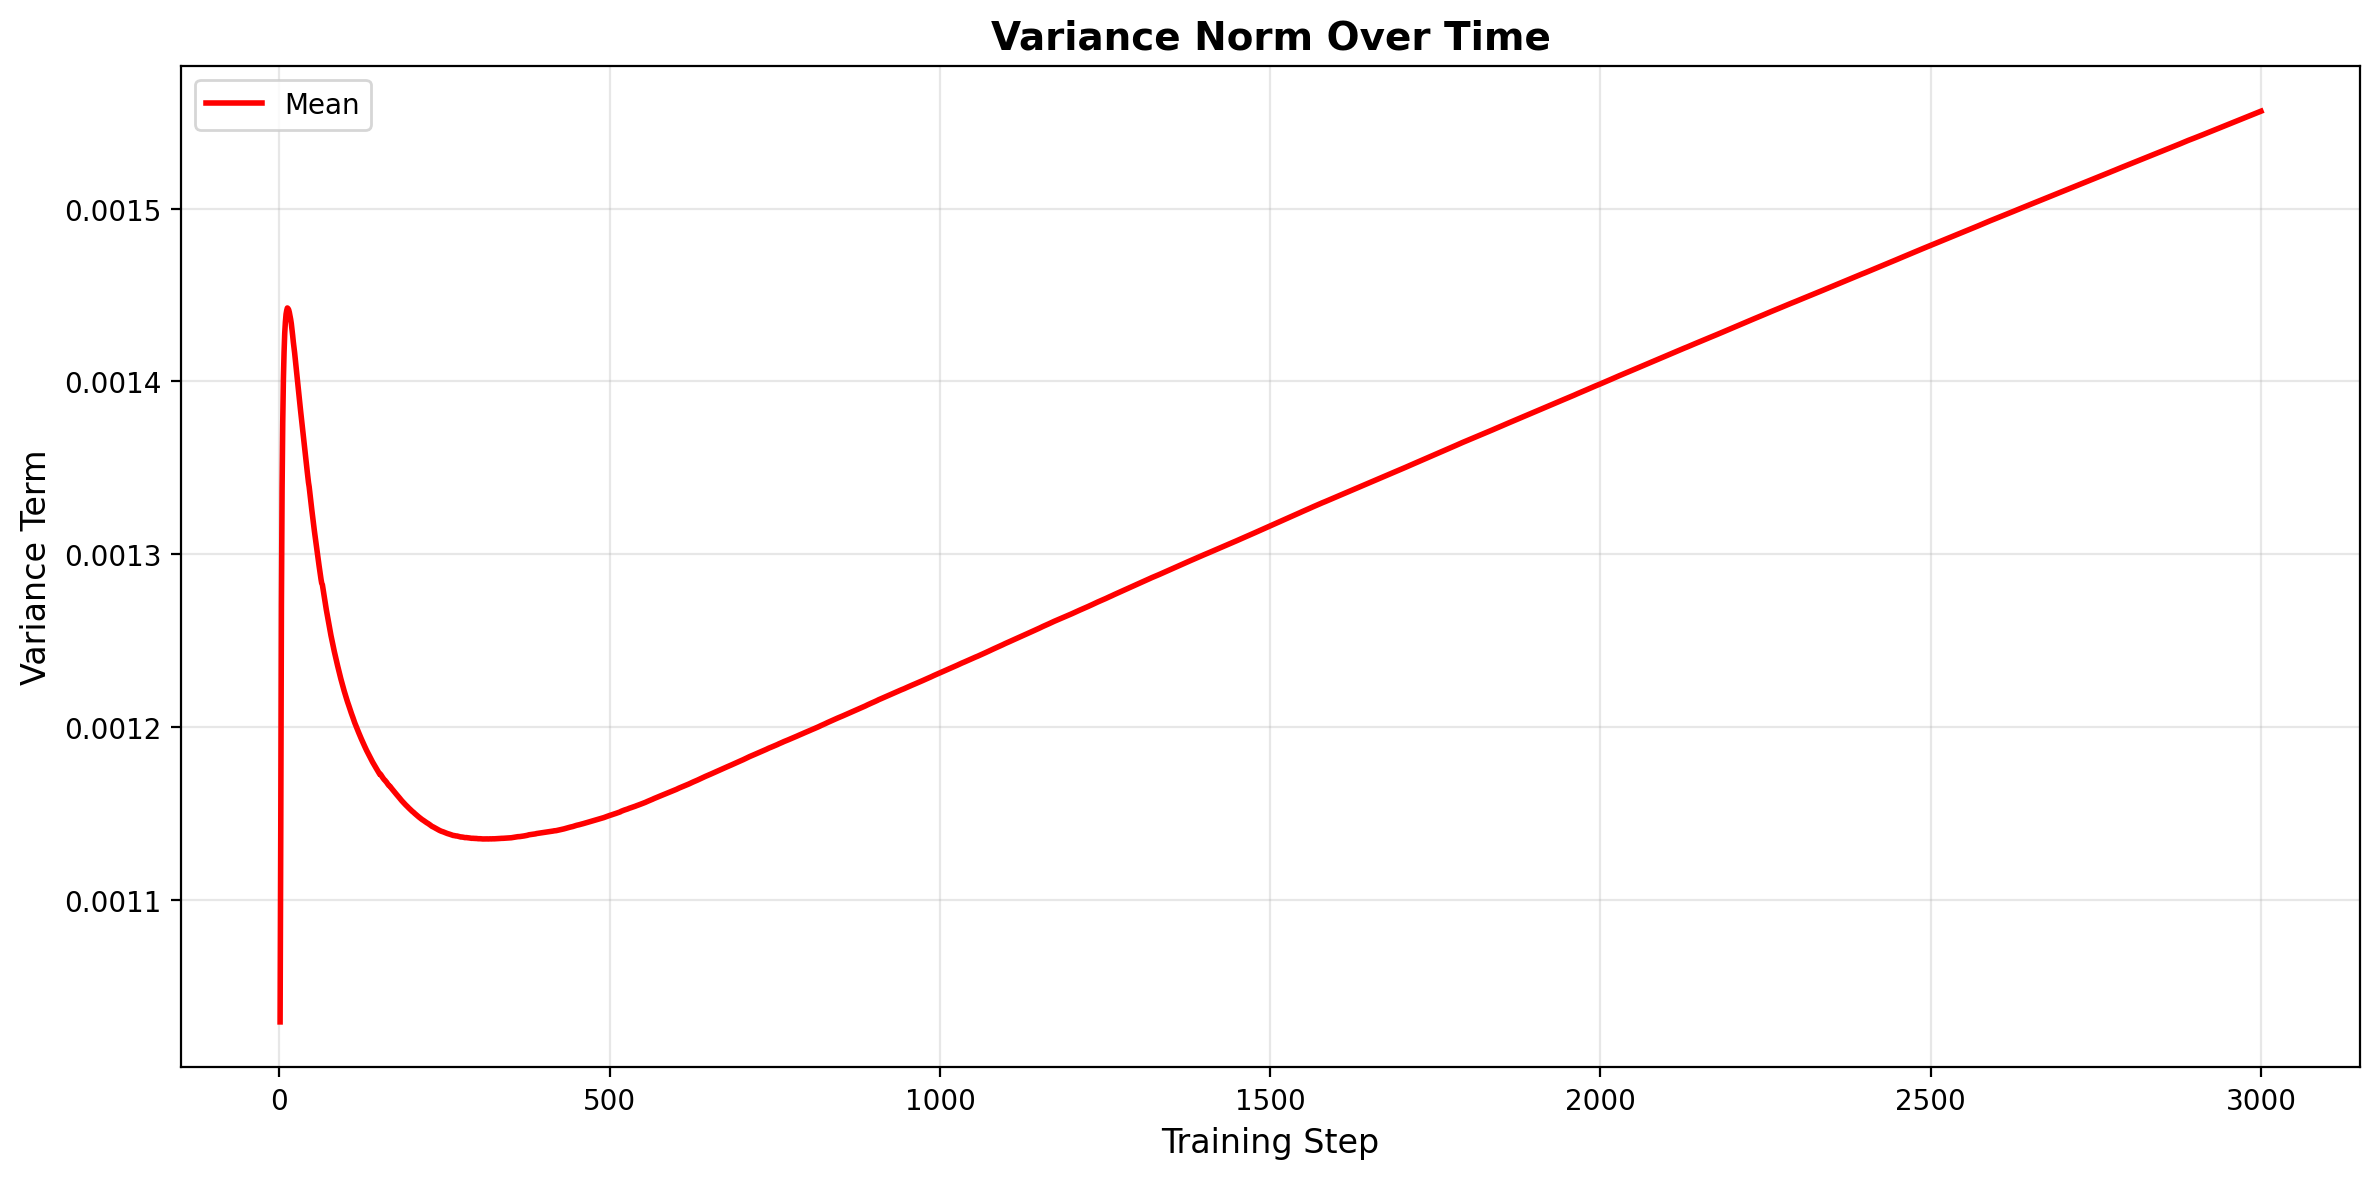

In [41]:
# Plot 3: Variance norm over time
fig, ax = plt.subplots(figsize=(12, 6), dpi=DPI)

# All tokens (faint)
# for i in range(num_tokens):
#     ax.plot(timesteps, sqrt_v_hat_norms[:, i].numpy(), color='steelblue', alpha=0.005, linewidth=0.5)

# Mean (bold)
ax.plot(timesteps, sqrt_v_hat_norms.mean(dim=1).numpy(), color='red', linewidth=2, label='Mean')

ax.set_xlabel('Training Step', fontsize=12)
ax.set_ylabel('Variance Term', fontsize=12)
ax.set_yscale('linear')
ax.set_title('Variance Norm Over Time', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()